

# Init


In [24]:
# Init data folder

from pathlib import Path

PATH_DATA_DIR = Path('./data')
PATH_DATA_DIR.mkdir(parents=True, exist_ok=True)

## Download raw data

In [25]:
# Define the directory and ensure it exists
PATH_RAW_DATA_DIR = PATH_DATA_DIR / 'raw'
PATH_RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
# Download raw data files
import json
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("princeton-nlp/SWE-bench")

# Function to save a dataset split to a JSON file
def save_dataset_to_json(dataset_split, filename):
    output_path = PATH_RAW_DATA_DIR / filename
    with output_path.open('w') as f:
        json.dump(list(dataset_split), f, indent=4)

# Save each dataset split to a corresponding JSON file
save_dataset_to_json(dataset['dev'], 'data-dev.json')
save_dataset_to_json(dataset['test'], 'data-test.json')
save_dataset_to_json(dataset['train'], 'data-train.json')

print("Datasets have been saved successfully.")


/home/matty/Uni/honours/thesis/swe-bench/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Datasets have been saved successfully.



## Preprocess raw data


In [4]:

PATH_REPOS_DIR = PATH_DATA_DIR / 'repos'
PATH_RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)


In [ ]:
import time
from pathlib import Path
from get_issues import get_issues
from clone_repos import clone_issues_repos

clone_issues_repos(PATH_REPOS_DIR, PATH_RAW_DATA_DIR / 'data-dev.json')
clone_issues_repos(PATH_REPOS_DIR, PATH_RAW_DATA_DIR / 'data-test.json')

print("Cloned repos.")



## Explore Data


In [26]:
from get_issues import get_issues

issues_dev = get_issues(PATH_RAW_DATA_DIR / 'data-dev.json')
issues_test = get_issues(PATH_RAW_DATA_DIR / 'data-test.json')
# get_issues(PATH_RAW_DATA_DIR / 'data-train.json')



In [27]:
issues_dev[0]



{'instance_id': 'sqlfluff__sqlfluff-4764',
 'repo': 'sqlfluff/sqlfluff',
 'repo_author': 'sqlfluff',
 'repo_name': 'sqlfluff',
 'base_commit': 'a820c139ccbe6d1865d73c4a459945cd69899f8f',
 'created_at': '2023-04-16T14:24:42Z',
 'version': '1.4',
 'problem_statement': 'Enable quiet mode/no-verbose in CLI for use in pre-commit hook\nThere seems to be only an option to increase the level of verbosity when using SQLFluff [CLI](https://docs.sqlfluff.com/en/stable/cli.html), not to limit it further.\r\n\r\nIt would be great to have an option to further limit the amount of prints when running `sqlfluff fix`, especially in combination with deployment using a pre-commit hook. For example, only print the return status and the number of fixes applied, similar to how it is when using `black` in a pre-commit hook:\r\n![image](https://user-images.githubusercontent.com/10177212/140480676-dc98d00b-4383-44f2-bb90-3301a6eedec2.png)\r\n\r\nThis hides the potentially long list of fixes that are being appli

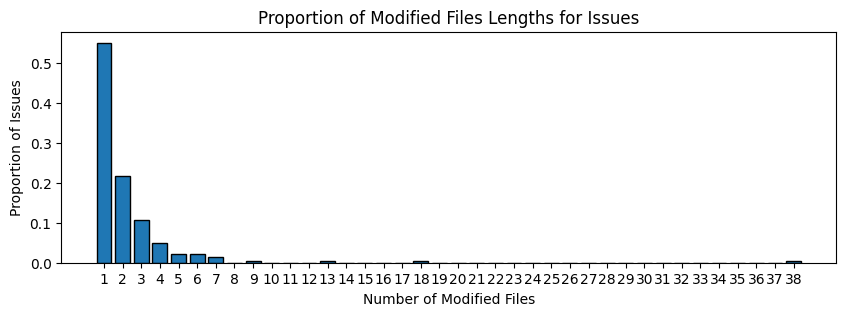

{1: 124, 2: 49, 3: 24, 4: 11, 5: 5, 6: 5, 7: 3, 9: 1, 13: 1, 18: 1, 38: 1}
Number of issues with >= 10 modified files: 3
Total number of issues: 225


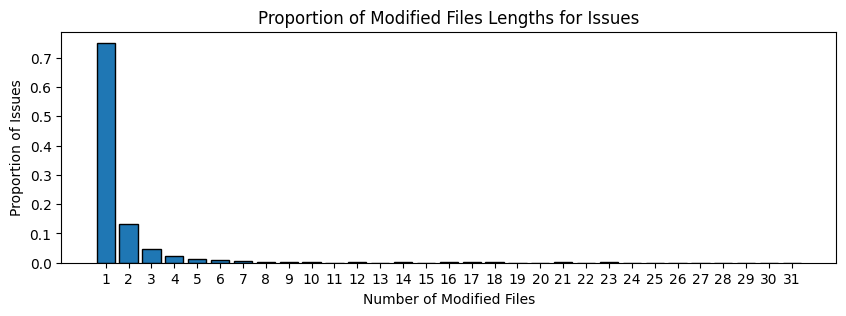

{1: 1724, 2: 307, 3: 108, 4: 50, 5: 31, 6: 18, 7: 14, 8: 7, 9: 7, 10: 3, 11: 1, 12: 3, 13: 1, 14: 2, 15: 1, 16: 4, 17: 4, 18: 3, 21: 2, 22: 1, 23: 2, 31: 1}
Number of issues with >= 10 modified files: 28
Total number of issues: 2294


In [28]:
import matplotlib.pyplot as plt

def plot_histogram_of_modified_files(issues):
    # Extract the lengths of the modified_files array for all issues
    lengths = [len(issue['modified_files']) for issue in issues]

    # Calculate the proportions
    total_issues = len(issues)
    proportions = [lengths.count(i) / total_issues for i in range(1, max(lengths) + 1)]

    # Create the histogram
    plt.figure(figsize=(10, 3))
    plt.bar(range(1, max(lengths) + 1), proportions, edgecolor='black', align='center')
    plt.xlabel('Number of Modified Files')
    plt.ylabel('Proportion of Issues')
    plt.title('Proportion of Modified Files Lengths for Issues')
    plt.xticks(range(1, max(lengths) + 1))
    plt.show()

def analyse_modified_files_count(issues):
    plot_histogram_of_modified_files(issues)

    # Extract the lengths of the modified_files array for all issues
    lengths = [len(issue['modified_files']) for issue in issues]

    # Calculate frequencies excluding zero values
    frequencies = {i: lengths.count(i) for i in range(1, max(lengths) + 1) if lengths.count(i) > 0}

    # Print frequencies
    print(frequencies)

    # Count issues with modified files greater than or equal to 10
    issues_with_many_files = len([issue for issue in issues if len(issue['modified_files']) >= 10])
    print(f'Number of issues with >= 10 modified files: {issues_with_many_files}')
    print(f'Total number of issues: {len(issues)}')

# Example usage
analyse_modified_files_count(issues_dev)
analyse_modified_files_count(issues_test)


In [8]:
# Get extensions of modified files

s = (sum([issue['modified_files'] for issue in issues_test], []))

print(len(set(s)))
print(len(s))

print(set([f.split(".")[-1] for f in s]))



1228
3802
{'ev/null', 'py'}


In [29]:

def filter_issues(issues):

    # Issues fixed with change to a single file change
    issues = [i for i in issues if len(i['modified_files']) == 1]
    
    return issues


issues_dev = filter_issues(issues_dev)
issues_test = filter_issues(issues_test)

# print(len(issues_dev))
# issues_dev[:10]


In [30]:

from pathlib import Path

class File:
    def __init__(self, path: Path):
        self._path = path
        self._content = self._load_file()

    def _load_file(self) -> str:
        return self._path.read_text()

    def __repr__(self):
        return f"File({str(self._path)})"
    
    @property
    def path(self) -> Path:
        return self._path

    @property
    def length(self) -> int:
        return len(self._content)

    @property
    def content(self) -> str:
        return self._content



In [31]:
from git import Repo


# Get a list of all files that are not gitignored
def get_repo_files(issue) -> list[File]:

    path_issue_repo = PATH_REPOS_DIR / issue["repo_name"]
    
    repo = Repo(path_issue_repo)
    repo.git.checkout(issue["base_commit"])

    # Use git ls-files to get a list of tracked .py files
    tracked_files = repo.git.ls_files('*.py').split('\n')
    # tracked_files = repo.git.ls_files().split('\n')
    
    # Filter out empty strings (if any)
    tracked_files = [f for f in tracked_files if f]
    
    # Get the absolute paths using pathlib
    tracked_files_paths = [path_issue_repo / f for f in tracked_files]

    repo_files = [File(p) for p in tracked_files_paths]
    
    return repo_files

# Example usage
issue = issues_dev[1]
repo_files = get_repo_files(issue)
# for file in python_files:
#     print(file)

# Output the list of .py files
len(repo_files)



310

In [33]:

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

"""
Make this a generic class for vector based methods.

That involve generically
- Generating vectors for all files
- Generating vector for query
- Comparing query vector with file vectors
- Maybe some reranking stuff

It should handle
- Ranking files by length? Maybe?
- Frequency vector model
- Regular TF-IDF vector model
- rVSM
- Complex embedding

"""

class IssueFileRanker:
    def __init__(self, issue):
        self.issue = issue
        self.repo_files = get_repo_files(issue)

    def get_tfidf_matrix(self):

        # Extract document contents
        documents = [file.content for file in self.repo_files]

        # Tokenize and generate the TF-IDF matrix
        self.vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.vectorizer.fit_transform(documents)
        
        # Output the TF-IDF matrix and feature names
        feature_names = self.vectorizer.get_feature_names_out()
        # print("TF-IDF matrix shape:", self.tfidf_matrix.shape)
        # print("Feature names:", feature_names[0:50])  # Print first 10 feature names as a sample


    def get_query_vector(self):
        query = self.issue["problem_statement"]
        self.query_vector = self.vectorizer.transform([query])
    

    def get_files_ranked(self) -> list[File]:
        self.get_tfidf_matrix()
        self.get_query_vector()
        
        # Calculate cosine similarity between the query and all documents
        similarity_scores = cosine_similarity(self.query_vector, self.tfidf_matrix).flatten()
        
        # Rank the documents by similarity
        ranked_indices = np.argsort(similarity_scores)[::-1]
        
        # Get the ranked documents scores
        ranked_scores = similarity_scores[ranked_indices]
        
        # Display the top 10 most similar documents
        results = []
        
        # print("Top 10 most similar documents:")
        for index, score in zip(ranked_indices, ranked_scores):
            # print(f"Document: {self.repo_files[index]}, Similarity Score: {score}")
            results.append( (index, self.repo_files[index], score) )

        return results

        # Optional: if you want to output the content of the most similar document
        # most_similar_doc_index = top_10_indices[0]
        # most_similar_doc_content = repo_python_files[most_similar_doc_index].content
        # print("Most similar document content:", most_similar_doc_content)


# file_ranker = IssueFileRanker(issues_dev[0])
# # print(file_ranker.query_vector)

# print(issues_dev[0]["modified_files"])
# list(enumerate(file_ranker.get_files_ranked()[:15]))


['src/sqlfluff/core/templaters/slicers/tracer.py']


[(0,
  (228,
   File(data/repos/sqlfluff/test/core/templaters/jinja_test.py),
   0.5286015056235585)),
 (1,
  (230,
   File(data/repos/sqlfluff/test/core/templaters/python_test.py),
   0.48656764719021844)),
 (2,
  (227,
   File(data/repos/sqlfluff/test/core/templaters/base_test.py),
   0.4415294011293783)),
 (3,
  (92,
   File(data/repos/sqlfluff/src/sqlfluff/core/templaters/base.py),
   0.35474199806894113)),
 (4,
  (95,
   File(data/repos/sqlfluff/src/sqlfluff/core/templaters/python.py),
   0.3316514696682706)),
 (5,
  (57,
   File(data/repos/sqlfluff/src/sqlfluff/core/parser/markers.py),
   0.23760879769197227)),
 (6,
  (86,
   File(data/repos/sqlfluff/src/sqlfluff/core/rules/functional/templated_file_slice_predicates.py),
   0.21153182365297096)),
 (7,
  (41,
   File(data/repos/sqlfluff/src/sqlfluff/core/linter/linted_file.py),
   0.20945292333161344)),
 (8,
  (87,
   File(data/repos/sqlfluff/src/sqlfluff/core/rules/functional/templated_file_slices.py),
   0.20478641976889367)),
 

In [53]:

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


class IssueFileRankerFileSize:
    def __init__(self, issue):
        self.issue = issue
        self.repo_files = get_repo_files(issue)


    def get_files_ranked(self) -> list:

        # Create a list of tuples with (index, file, score)
        files_with_scores = [(index, f, f.length) for index, f in enumerate(self.repo_files)]
        # Sort the list of tuples by score (length) in descending order
        sorted_files_with_scores = sorted(files_with_scores, key=lambda x: x[2], reverse=True)

        return sorted_files_with_scores

file_ranker = IssueFileRankerFileSize(issues_dev[0])
# print(file_ranker.query_vector)


print(issues_dev[0]["modified_files"])
list(enumerate(file_ranker.get_files_ranked()[:15]))


['src/sqlfluff/core/templaters/slicers/tracer.py']


[(0,
  (116,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_snowflake.py),
   163888)),
 (1,
  (112,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_postgres.py),
   134332)),
 (2,
  (123,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_tsql.py),
   124941)),
 (3,
  (100,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_ansi.py),
   119654)),
 (4,
  (105,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_exasol.py),
   99483)),
 (5,
  (119,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_sparksql.py),
   80681)),
 (6,
  (109,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_mysql.py),
   62344)),
 (7,
  (65,
   File(data/repos/sqlfluff/src/sqlfluff/core/parser/segments/base.py),
   60658)),
 (8,
  (114,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_redshift.py),
   58979)),
 (9,
  (102,
   File(data/repos/sqlfluff/src/sqlfluff/dialects/dialect_bigquery.py),
   56610)),
 (10, (201, File(data/repos/sqlfluff/te

In [54]:

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import random


class IssueFileRankerRandom:
    def __init__(self, issue):
        self.issue = issue
        self.repo_files = get_repo_files(issue)


    def get_files_ranked(self) -> list:

        # Create a list of tuples with (index, file, score)
        files_with_scores = [(index, f, random.random()) for index, f in enumerate(self.repo_files)]
        # Sort the list of tuples by score (length) in descending order
        sorted_files_with_scores = sorted(files_with_scores, key=lambda x: x[2], reverse=True)

        return sorted_files_with_scores

file_ranker = IssueFileRankerRandom(issues_dev[0])
# print(file_ranker.query_vector)


print(issues_dev[0]["modified_files"])
list(enumerate(file_ranker.get_files_ranked()[:15]))



['src/sqlfluff/core/templaters/slicers/tracer.py']


[(0,
  (62,
   File(data/repos/sqlfluff/src/sqlfluff/core/parser/parser.py),
   0.9990325603781969)),
 (1,
  (27,
   File(data/repos/sqlfluff/src/sqlfluff/cli/helpers.py),
   0.9984183775561487)),
 (2,
  (254,
   File(data/repos/sqlfluff/test/rules/std_L003_test.py),
   0.9977328418235054)),
 (3,
  (142,
   File(data/repos/sqlfluff/src/sqlfluff/rules/L017.py),
   0.9954099982253295)),
 (4,
  (9,
   File(data/repos/sqlfluff/plugins/sqlfluff-templater-dbt/sqlfluff_templater_dbt/__init__.py),
   0.9949898316360185)),
 (5,
  (245,
   File(data/repos/sqlfluff/test/fixtures/templater/jinja_j_libraries/libs/foo.py),
   0.9935587914824942)),
 (6,
  (12,
   File(data/repos/sqlfluff/plugins/sqlfluff-templater-dbt/test/fixtures/dbt/templater.py),
   0.9887203002035911)),
 (7,
  (38,
   File(data/repos/sqlfluff/src/sqlfluff/core/linter/__init__.py),
   0.9811389842841012)),
 (8,
  (225,
   File(data/repos/sqlfluff/test/core/string_helpers_test.py),
   0.9736062354504577)),
 (9,
  (64,
   File(data

In [66]:


import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

"""
Make this a generic class for vector based methods.

That involve generically
- Generating vectors for all files
- Generating vector for query
- Comparing query vector with file vectors
- Maybe some reranking stuff

It should handle
- Ranking files by length? Maybe?
- Frequency vector model
- Regular TF-IDF vector model
- rVSM
- Complex embedding

"""
import math

class IssueFileRankerRVSM:
    def __init__(self, issue):
        self.issue = issue
        self.repo_files = get_repo_files(issue)

    def get_tfidf_matrix(self):

        # Extract document contents
        documents = [file.content for file in self.repo_files]

        # Tokenize and generate the TF-IDF matrix
        self.vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.vectorizer.fit_transform(documents)
        
        # Output the TF-IDF matrix and feature names
        feature_names = self.vectorizer.get_feature_names_out()
        # print("TF-IDF matrix shape:", self.tfidf_matrix.shape)
        # print("Feature names:", feature_names[0:50])  # Print first 10 feature names as a sample


    def get_query_vector(self):
        query = self.issue["problem_statement"]
        self.query_vector = self.vectorizer.transform([query])
    

    def get_files_ranked(self) -> list[File]:
        self.get_tfidf_matrix()
        self.get_query_vector()
        
        # Calculate cosine similarity between the query and all documents
        similarity_scores = cosine_similarity(self.query_vector, self.tfidf_matrix).flatten()

        # print(similarity_scores)

        min_length = min(f.length for f in self.repo_files)
        max_length = max(f.length for f in self.repo_files)
        # print(min_length, max_length)
        
        for i in range(len(similarity_scores)):
            # imo this is bad and we should instead use a zscore or smth like that to remove outliers?
            # otherwise feels like all outliers are winning?
            length_norm = (self.repo_files[i].length - min_length) / (max_length - min_length)
            g = 1 / (1 + math.exp(-1 * length_norm))
            # print(g)

            similarity_scores[i] = similarity_scores[i] * g

        # print(similarity_scores)
        
        # Rank the documents by similarity
        ranked_indices = np.argsort(similarity_scores)[::-1]
        
        # Get the ranked documents scores
        ranked_scores = similarity_scores[ranked_indices]
        
        # Display the top 10 most similar documents
        results = []
        
        # print("Top 10 most similar documents:")
        for index, score in zip(ranked_indices, ranked_scores):
            # print(f"Document: {self.repo_files[index]}, Similarity Score: {score}")
            results.append( (index, self.repo_files[index], score) )

        return results

        # Optional: if you want to output the content of the most similar document
        # most_similar_doc_index = top_10_indices[0]
        # most_similar_doc_content = repo_python_files[most_similar_doc_index].content
        # print("Most similar document content:", most_similar_doc_content)


file_ranker = IssueFileRankerRVSM(issues_dev[0])
# print(file_ranker.query_vector)

# print(issues_dev[0]["modified_files"])
list(enumerate(file_ranker.get_files_ranked()[:3]))




[(0,
  (228,
   File(data/repos/sqlfluff/test/core/templaters/jinja_test.py),
   0.2976989824258988)),
 (1,
  (230,
   File(data/repos/sqlfluff/test/core/templaters/python_test.py),
   0.2554671367526452)),
 (2,
  (227,
   File(data/repos/sqlfluff/test/core/templaters/base_test.py),
   0.22780902219520963))]

In [38]:


def eval_issue_single(issue, ranked_files:list[File]):

    assert len(issue["modified_files"]) == 1, "Not yet implemented multi-file eval"
    
    # print()
    # print(issue["instance_id"])
    # print(issue["pr_url"])
    
    path_issue_repo = PATH_REPOS_DIR / issue["repo_name"]
    f = File(path_issue_repo / issue["modified_files"][0])
    # print(f)

    # print(file_ranker.get_files_ranked()[0])

    top = f.path == ranked_files[0][1].path

    # print(issue["instance_id"], top)
    
    return top



In [49]:

def eval_issues(issues, file_ranker_type:type[IssueFileRanker]):
    
    c = 0
    cc = 0
    
    for i,issue in enumerate(issues):
    
        file_ranker = file_ranker_type(issue)
        # print(file_ranker.query_vector)
        # print(file_ranker.get_files_ranked()[0])

        try:
            r = eval_issue_single(issue, file_ranker.get_files_ranked())
        
            c += 1
            if r: cc += 1
        except:
            print("Failed", issue["instance_id"])
    
        if i%10==0:
            print("Progress", i, len(issues))

    print(cc, c, cc/c)
    



In [52]:

eval_issues(issues_dev, IssueFileRanker)


Progress 0 124
Progress 10 124
Progress 20 124
Failed sqlfluff__sqlfluff-3330
Progress 30 124
Failed pvlib__pvlib-python-807
Progress 40 124
Progress 50 124
Progress 60 124
Progress 70 124
Progress 80 124
Progress 90 124
Progress 100 124
Progress 110 124
Progress 120 124
31 122 0.2540983606557377


In [51]:

eval_issues(issues_dev, IssueFileRankerFileSize)


Progress 0 124
Progress 10 124
Progress 20 124
Failed sqlfluff__sqlfluff-3330
Progress 30 124
Failed pvlib__pvlib-python-807
Progress 40 124
Progress 50 124
Progress 60 124
Progress 70 124
Progress 80 124
Progress 90 124
Progress 100 124
Progress 110 124
Progress 120 124
3 122 0.02459016393442623


In [55]:

eval_issues(issues_dev, IssueFileRankerRandom)



Progress 0 124
Progress 10 124
Progress 20 124
Failed sqlfluff__sqlfluff-3330
Progress 30 124
Failed pvlib__pvlib-python-807
Progress 40 124
Progress 50 124
Progress 60 124
Progress 70 124
Progress 80 124
Progress 90 124
Progress 100 124
Progress 110 124
Progress 120 124
1 122 0.00819672131147541


In [67]:

eval_issues(issues_dev, IssueFileRankerRVSM)


Progress 0 124
Progress 10 124
Progress 20 124
Failed sqlfluff__sqlfluff-3330
Progress 30 124
Failed pvlib__pvlib-python-807
Progress 40 124
Progress 50 124
Progress 60 124
Progress 70 124
Progress 80 124
Progress 90 124
Progress 100 124
Progress 110 124
Progress 120 124
33 122 0.27049180327868855


In [37]:

tfidf_matrix


NameError: name 'tfidf_matrix' is not defined

<1x12714 sparse matrix of type '<class 'numpy.float64'>'
	with 92 stored elements in Compressed Sparse Row format>

Top 10 most similar documents:
Document: data/repos/sqlfluff/test/core/string_helpers_test.py, Similarity Score: 0.20652214978019448
Document: data/repos/sqlfluff/src/sqlfluff/core/rules/functional/raw_file_slice_predicates.py, Similarity Score: 0.17802386354667865
Document: data/repos/sqlfluff/src/sqlfluff/cli/formatters.py, Similarity Score: 0.171805511869652
Document: data/repos/sqlfluff/src/sqlfluff/core/rules/analysis/select.py, Similarity Score: 0.15386813406989214
Document: data/repos/sqlfluff/src/sqlfluff/core/linter/linting_result.py, Similarity Score: 0.14885331496873092
Document: data/repos/sqlfluff/test/rules/std_L020_test.py, Similarity Score: 0.13896633898896787
Document: data/repos/sqlfluff/src/sqlfluff/__init__.py, Similarity Score: 0.13549766000895547
Document: data/repos/sqlfluff/src/sqlfluff/core/dialects/__init__.py, Similarity Score: 0.1307772152583765
Document: data/repos/sqlfluff/src/sqlfluff/rules/L054.py, Similarity Score: 0.12791470058533874
Document: data/rep

IndexError: list index out of range

array([225,  82,  26,  76,  43, 260,  18,  32, 179, 174,  66, 234, 297,
       131,   0,   3, 287, 130,  50,  25, 129, 252, 222,  22, 172, 285,
       183, 289, 263, 186, 298, 237,  30,  34, 213, 209, 163,  24, 253,
       147,  45, 226,  10, 128, 155,  53, 158, 177, 214, 142, 261, 144,
       294, 178, 136,  55,  51, 229, 291, 196,  69,  40,  42,  33, 152,
         1, 220,  86, 184,  85, 181, 170, 133, 281, 125, 309, 151,  37,
        68, 149, 283, 308, 126, 153, 185, 166,  88, 140, 132,  67,  52,
         6, 217, 135, 148,  77,  80, 244, 150, 208,  54, 187, 246, 168,
       299, 221, 235,  49,  14, 198, 262,  47, 193,  20,  98, 236, 156,
       138,  78, 189, 211, 101, 242, 160, 137, 210,  63, 241,  58, 162,
       267, 141, 259, 286,  16, 288,  57, 266,  44, 124, 110, 197, 175,
       231,  90,  97, 188, 180, 143, 282, 302, 159, 303, 157,  81, 173,
        64, 134, 192, 127, 171,  41, 119, 223, 233, 301,  89, 292, 164,
       305, 215, 307, 238, 182, 122,   2, 207, 121, 139, 165, 11

In [182]:

issue["modified_files"]


['src/sqlfluff/cli/commands.py']

In [143]:

f = repo_files[0]
f.length
print(f.content)
print(f.path)
f



"""Configuration file for the Sphinx documentation builder.

This file only contains a selection of the most common options. For a full
list see the documentation:
https://www.sphinx-doc.org/en/master/usage/configuration.html
"""

import configparser

# -- Path setup --------------------------------------------------------------

# If extensions (or modules to document with autodoc) are in another directory,
# add these directories to sys.path here. If the directory is relative to the
# documentation root, use os.path.abspath to make it absolute, like shown here.
#
# import os
# import sys
# sys.path.insert(0, os.path.abspath('.'))

# Get the global config info as currently stated
# (we use the config file to avoid actually loading any python here)
config = configparser.ConfigParser()
config.read(["../../setup.cfg"])
stable_version = config.get("sqlfluff_docs", "stable_version")

# -- Project information -----------------------------------------------------

project = "SQLFluff"
copyri

File(data/repos/sqlfluff/docs/source/conf.py)

In [90]:


f.path


PosixPath('/home/matty/Uni/honours/thesis/swe-bench/data/repos/sqlfluff/docs/source/conf.py')